In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from utilities.imports import *

In [3]:
dataset_path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
transforms = [make_rgb, ResizedFixed(128), to_byte_tensor, to_float_tensor]
bs=128
loss_function = F.cross_entropy
num_filters = [32,64,128,256]
num_channels =3
num_categories = 10
callback_funcs = [partial(AvgStatsCallback, accuracy), CudaCallback, partial(IndependentVarBatchTransformCallback, normalize_imagenette)]
image_list = ImageList.from_files(dataset_path, tfms=transforms)
split_data = SplitData.split_by_function(image_list, partial(grandparent_splitter, valid_name="val"))
labeled_data = label_by_func(split_data, parent_labeler, proc_y=CategoryProcessor())
train_dl = torch.utils.data.DataLoader(labeled_data.train, bs, shuffle = True)
valid_dl = torch.utils.data.DataLoader(labeled_data.valid, bs*2, shuffle = False)

In [4]:
img = PIL.Image.open(image_list.items[0])
print(type(img))
print(type(image_list.items[0]))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'pathlib.WindowsPath'>


# Image Augmentation

### flipping

In [5]:
def two_step_resize(image, x_size, y_size):
    """takes a path or PIL.Image and returns it after a bicubic and nearest neighbor resizing using PIL.resize"""
    size = (x_size, y_size)
    ret_img = PIL.Image
    if isinstance(image, PIL.Image.Image):
        ret_img = image.resize(size, resample=PIL.Image.BICUBIC).resize(size, resample = PIL.Image.NEAREST)
    elif isinstance(image, pathlib.Path):
        img = PIL.Image.open(image)
        ret_img = two_step_resize(img, x_size, y_size)
    else:
        raise TypeError("image must be a Pathlib.Path or PIL.Image.Image")
    return ret_img
def PIL_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < 0.5 else x

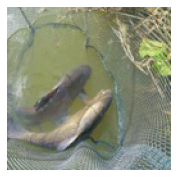

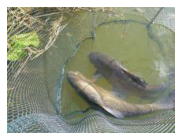

In [6]:
show_image(PIL_random_flip(two_step_resize(img, 128,128)))
show_image(img)

### testing show_batch(), with/without-out augmentations

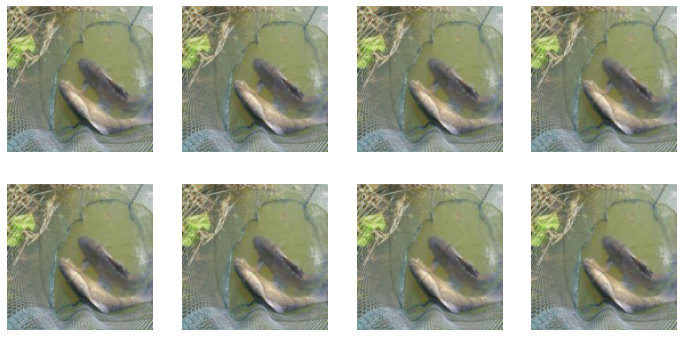

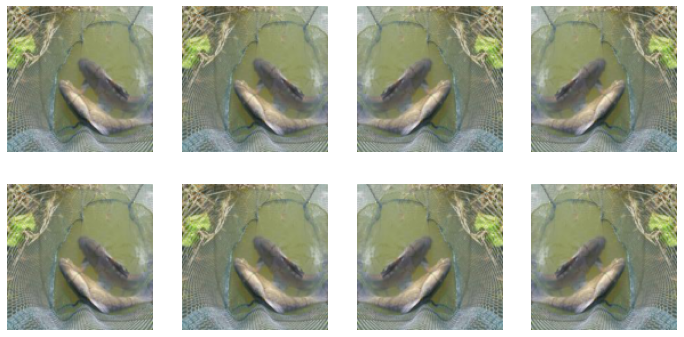

In [10]:
def get_il(tfms): return ImageList.from_files(dataset_path, tfms=tfms)
il1 = get_il(transforms)
il1.items = [il1.items[0]]*64
dl = torch.utils.data.DataLoader(il1, 8)
x = next(iter(dl))
show_batch(x)

#show batch with random flips
il1.tfms.append(PIL_random_flip)
x = next(iter(dl))
show_batch(x)

In [17]:
class PIL_Transform(Transform): 
    _order=11 #give all PIL transforms the same order

class PIL_Rand_Flip(PIL_Transform):
    _order = 11
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        return img.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else img
    
class PIL_Rand_Dihedral(PIL_Transform):
    def __init__(self, p=0.75): self.p=p*7/8 #Little hack to get the 1/8 identity dihedral transform taken into account.
    def __call__(self, x):
        if random.random()>self.p: return x
        return x.transpose(random.randint(0,6))

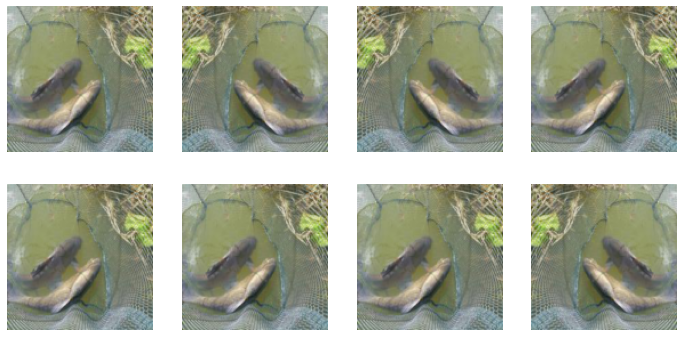

In [18]:
del(il1.tfms[-1])
il1.tfms.append(PIL_Rand_Flip(0.8))
x = next(iter(dl))
show_batch(x)

In [19]:
class General_Crop(PIL_Transform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR): 
        self.resample,self.size = resample,process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w,h): return default_crop_size(w,h)

    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h): return (0,0,w,h)

#deterministic for the validation set, no stochastic augmentations
class Center_Crop(General_Crop):
    """crops to the center of the image"""
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

### Augmentation for Training Set: Stochastic Augmentation

In [20]:
class Rand_Resized_Crop(General_Crop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale,self.ratio = scale,ratio
    
    def get_corners(self, w, h, wc, hc):
        area = w*h
        #Tries 10 times to get a proper crop inside the image.
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to squish
        if   w/h < self.ratio[0]: size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: size = (int(h*self.ratio[1]), h)
        else:                     size = (w, h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)

# Perspective Warping

In [29]:
# export
from torch import FloatTensor,LongTensor

def process_sz(sz):
    sz = convert_to_list(sz)
    return tuple(sz if len(sz)==2 else [sz[0],sz[0]])

def default_crop_size(w,h): return [w,w] if w < h else [h,h]

def uniform(a,b): return a + (b-a) * random.random()

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0]) #solve the system of linear equations

def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

class PIL_Perspective_Rand_Crop(PIL_Transform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST): 
        self.resample,self.size,self.magnitude = resample,process_sz(size),magnitude
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def __call__(self, x):
        csize = default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [30]:
#numpy array to torch tensor
def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

## GPU Batch Data Augmentation

In [31]:
il1.tfms = [make_rgb, PIL_Perspective_Rand_Crop(128, magnitude=0.2), to_byte_tensor, to_float_tensor]

In [36]:
from torch import FloatTensor
def affine_grid_cpu(size):
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

def affine_grid(x, size):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    if x.device.type == 'cpu': return affine_grid_cpu(size) 
    m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [37]:
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)
thetas = torch.empty(x.size(0)).uniform_(-30,30)
m = rotation_matrix(thetas)

NameError: name 'stack' is not defined

In [34]:
from torch.jit import script
grid = grid.cuda()
m = m.cuda()
tfm_x = F.grid_sample(x, tfm_grid.cpu(), padding_mode='reflection')
m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
@script
def rotate_batch(x, size, degrees):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    grid = F.affine_grid(m[:,:2], size)
    return F.grid_sample(x.cuda(), grid)

NameError: name 'tfm_grid' is not defined

In [ ]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)